In [1]:
import sys
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union
from itertools import combinations

sys.path.append(str(Path.cwd()))
sys.path.append(str(Path.cwd().parent/'scripts'))

from _helpers import generate_color_list
from industry_cluster_analysis import (
    get_costoptimal_network,
    get_partitions,
    plot_network,
    get_plant_capex,
    get_heat_network,
)

0.9455705593530577


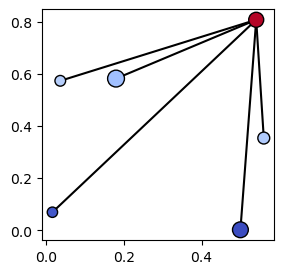

In [2]:
n = 6

sample_sites = np.random.uniform(0, 1, (n, 2))
sample_temps = np.random.uniform(80, 250, n).tolist()
sample_caps = np.random.uniform(1, 5, n).tolist()

sample_network, sample_cost = get_costoptimal_network(sample_sites, sample_temps, sample_caps)

print(sample_cost)
plot_network(sample_network, sample_sites, sample_caps, sample_temps)

In [3]:
shape = gpd.read_file(Path.cwd() /
        'misc_data' /
        'zip_data' /
        'backup_copy' /
        'resources' /
        'US_2021' /
        'bus_regions' /
        'regions_onshore_elec_s_100flex.geojson' /
        'regions_onshore_elec_s_100flex.geojson'
        )

usa_total = gpd.GeoDataFrame(geometry=[unary_union(shape['geometry'])]).set_crs(shape.crs)

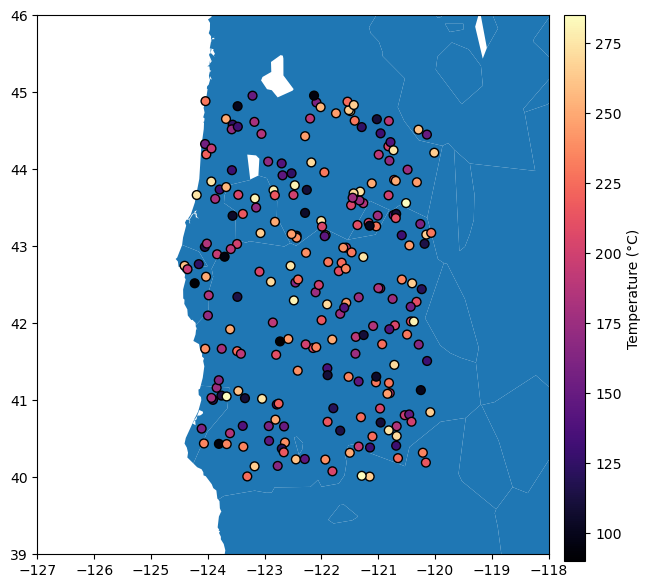

In [4]:
n = 500

t_levels = [90 + i*5 for i in range(40)]

sites = gpd.GeoDataFrame(
    {
        'demand': np.random.uniform(1, 10, n),
        'temperature': np.random.choice(t_levels, n, replace=True)
        },
    geometry=gpd.points_from_xy(
        # np.random.uniform(-130, -60, 1000),
        # np.random.uniform(25, 50, 1000)
        np.random.uniform(-130, -120, n),
        np.random.uniform(40, 45, n)
        )
    ).set_crs(epsg=4326)

# sites = sites.sjoin(usa_total, how='inner')
sites = sites.sjoin(shape, how='inner')
fig, ax = plt.subplots(figsize=(7, 7))

shape.plot(ax=ax)
sites.plot(
    ax=ax,
    # color='red',
    column='temperature',
    cmap='magma',
    edgecolor='black',
    markersize=40
    )

cax = fig.add_axes([0.9, 0.1, 0.03, 0.78])

norm = plt.Normalize(vmin=sites['temperature'].min(), vmax=sites['temperature'].max())
sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
fig.colorbar(sm, cax=cax)
cax.set_ylabel('Temperature (°C)')

ax.set_xlim(-127, -118)
ax.set_ylim(39, 46)

plt.show()

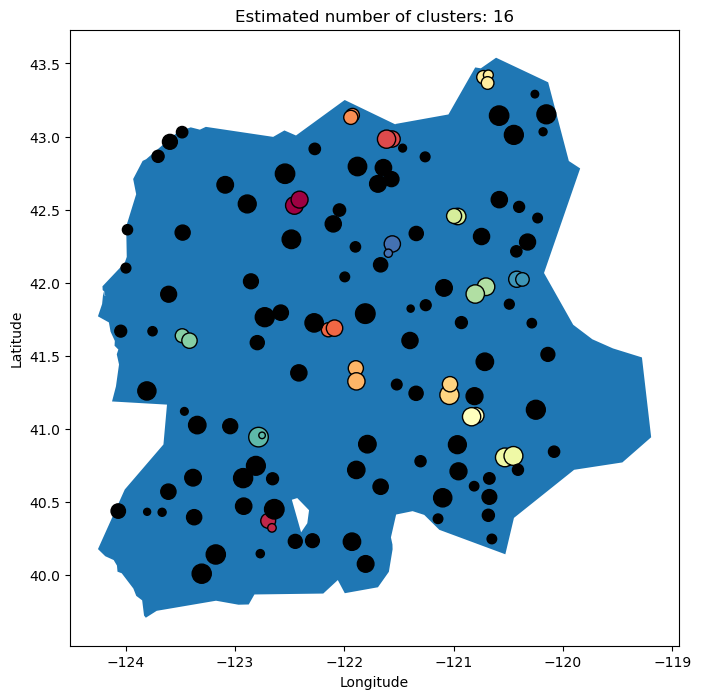

In [5]:
# from shapely.geometry import MultiPoint
# from sklearn.metrics.pairwise import haversine_distances


pipe_price = 100

threshold_distance_km = 10
threshold_distance_rad = threshold_distance_km / 6371.0


for index_right in sites.index_right.value_counts().index:

    ss = sites.loc[sites.index_right == index_right]

    if ss.empty:
        continue

    sites_np = np.array([ss['geometry'].y, ss['geometry'].x]).T

    db = DBSCAN(
        eps=threshold_distance_rad,
        min_samples=2,
        metric='haversine').fit(np.radians(sites_np))

    labels = db.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    shape.loc[[index_right]].plot(ax=ax)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    caps, capex, cluster_size = [], [], []

    for k, col in zip(unique_labels, colors):

        class_member_mask = (labels == k)

        xy = sites_np[class_member_mask]
        size = ss.iloc[class_member_mask]['demand']
        temps = ss.iloc[class_member_mask]['temperature']

        if k == -1:
            col = [0, 0, 0, 1]

            caps.extend(size)
            capex.extend(get_plant_capex(np.array(size)))
            cluster_size.extend([1] * len(size))

        else:
            partitions = get_partitions(list(range(len(xy))))
            partition_costs = []
            disagg_partition_costs = []

            partition_caps = []
            partition_cluster_sizes = []

            for i, partition in enumerate(partitions):

                n_cost = []
                n_caps = []
                n_cluster_size = []

                # partition discarded if no monotonically decreasing
                # temperature levels are found
                partition_eligible = False 

                # print(partition)

                for n_idx in partition:

                    n_xy = xy[[n_idx]][0]
                    n_temp = temps.iloc[list(n_idx)].tolist()
                    n_size = size.iloc[list(n_idx)]
                    n_cluster_size.append(len(n_idx))

                    total_caps, total_cost = get_heat_network(n_xy, n_temp, n_size, pipe_price)

                    # print(len(n_temp), total_caps, total_cost)
                    n_cost.append(total_cost)
                    n_caps.append(total_caps)


                # if not isinstance(sum(n_cost), float):
                #     partition_costs.append)

                partition_costs.append(sum(n_cost))
                disagg_partition_costs.append(n_cost)
                partition_caps.append(n_caps)
                partition_cluster_sizes.append(n_cluster_size)

            # print('partition_costs')
            # print(partition_costs)
            # print(disagg_partition_costs)
            # print(np.argmin(partition_costs))

            best_partition = partitions[np.argmin(partition_costs)]
            best_partition_caps = partition_caps[np.argmin(partition_costs)]
            best_disagg_partition_costs = disagg_partition_costs[np.argmin(partition_costs)]
            best_partition_cluster_sizes = partition_cluster_sizes[np.argmin(partition_costs)]

            for ca, co, cl in zip(
                best_partition_caps,
                best_disagg_partition_costs,
                best_partition_cluster_sizes
                ):

                caps.append(ca)
                capex.append(co)
                cluster_size.append(cl)


        ax.scatter(
            xy[:, 1],
            xy[:, 0],
            color=tuple(col),
            edgecolor='k',
            alpha=1,
            s=size*20
            )


    ax.set_title(f'Estimated number of clusters: {n_clusters}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    # ax.set_xlim(xy[:, 1].min() - 0.1, xy[:, 1].max() + 0.1)
    # ax.set_ylim(xy[:, 0].min() - 0.1, xy[:, 0].max() + 0.1)
    plt.show()
    break

In [6]:
region_df = pd.DataFrame({
    'caps': caps,
    'capex': capex,
    'cluster_size': cluster_size
}).sort_values('capex')

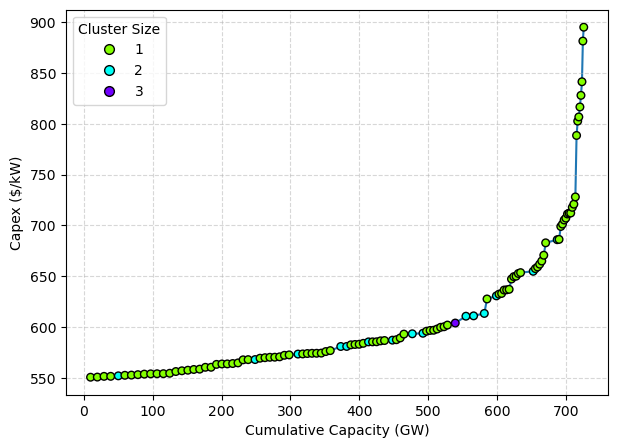

In [7]:
region_df['cumcap'] = region_df['caps'].cumsum()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(region_df['cumcap'], region_df['capex'], zorder=1)

color_list = generate_color_list(max(region_df['cluster_size']) + 1)
c = [color_list[i] for i in region_df['cluster_size']]

ax.scatter(region_df['cumcap'], region_df['capex'], c=c, s=30, edgecolor='k', zorder=2)
ax.set_xlabel('Cumulative Capacity (GW)')
ax.set_ylabel('Capex ($/kW)')

# ax.set_xlim(-10, 770)
# ax.set_ylim(500, 1040)
ax.grid(True, linestyle='--', alpha=0.5)

labels = region_df['cluster_size'].unique()
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[i], markersize=7,
               markeredgecolor='k', label=f'{i} sites')
           for i in labels]

ax.legend(handles, labels, title='Cluster Size', loc='upper left')


plt.show()

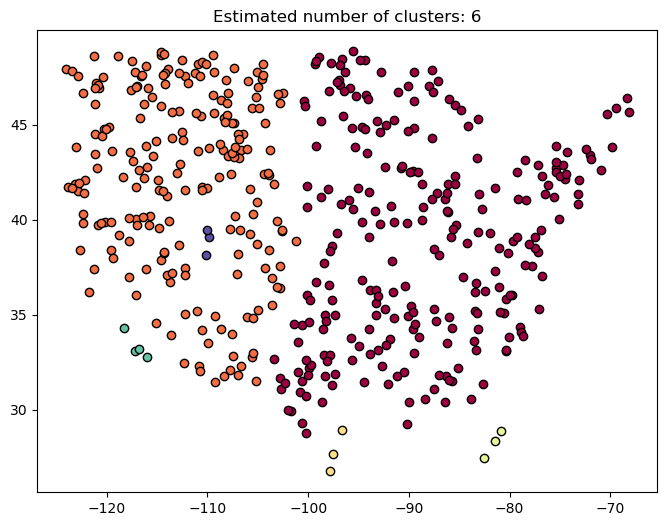

In [13]:
threshold_distance = 2

# Perform DBSCAN clustering
db = DBSCAN(eps=threshold_distance, min_samples=2).fit(sites_np)
labels = db.labels_


# Number of clusters (ignoring noise if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plot the results
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = sites_np[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.show()


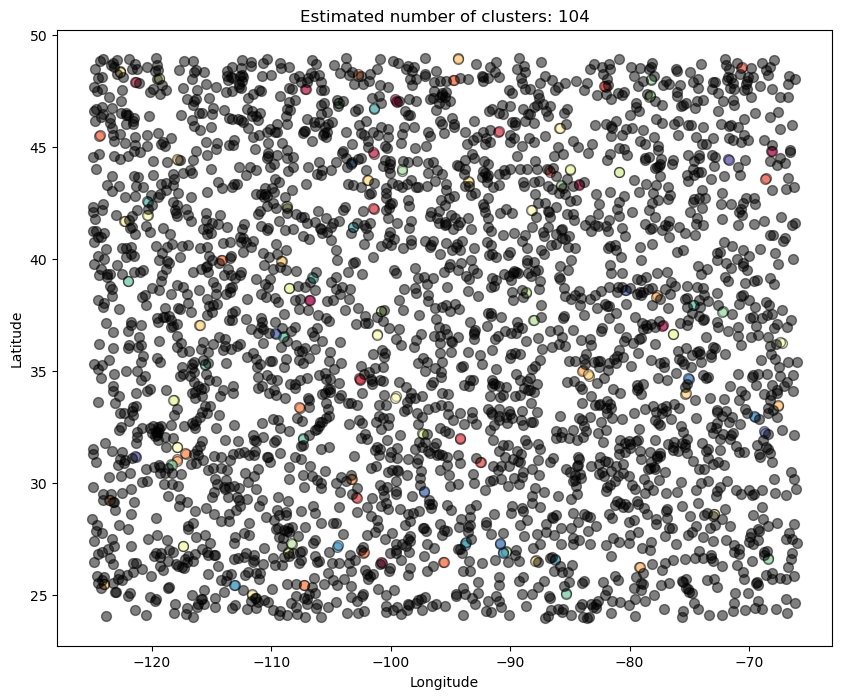

In [16]:
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
import matplotlib.pyplot as plt

latitudes = np.random.uniform(low=24, high=49, size=3000)
longitudes = np.random.uniform(low=-125, high=-66, size=3000)
sites = np.vstack((latitudes, longitudes)).T

# Define the maximum distance for a cluster in kilometers
threshold_distance_km = 10

# Convert the threshold distance from kilometers to radians (for use with geodesic distance)
threshold_distance_rad = threshold_distance_km / 6371.0  # Earth's radius in km

# Perform DBSCAN clustering based on geographical distance
db = DBSCAN(eps=threshold_distance_rad, min_samples=2, metric='haversine').fit(np.radians(sites))
labels = db.labels_

# Number of clusters (ignoring noise if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plotting the results (not geographically accurate but illustrative)
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise

    class_member_mask = (labels == k)
    xy = sites[class_member_mask]
    plt.scatter(xy[:, 1], xy[:, 0], color=tuple(col), edgecolor='k', s=50, alpha=0.5)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


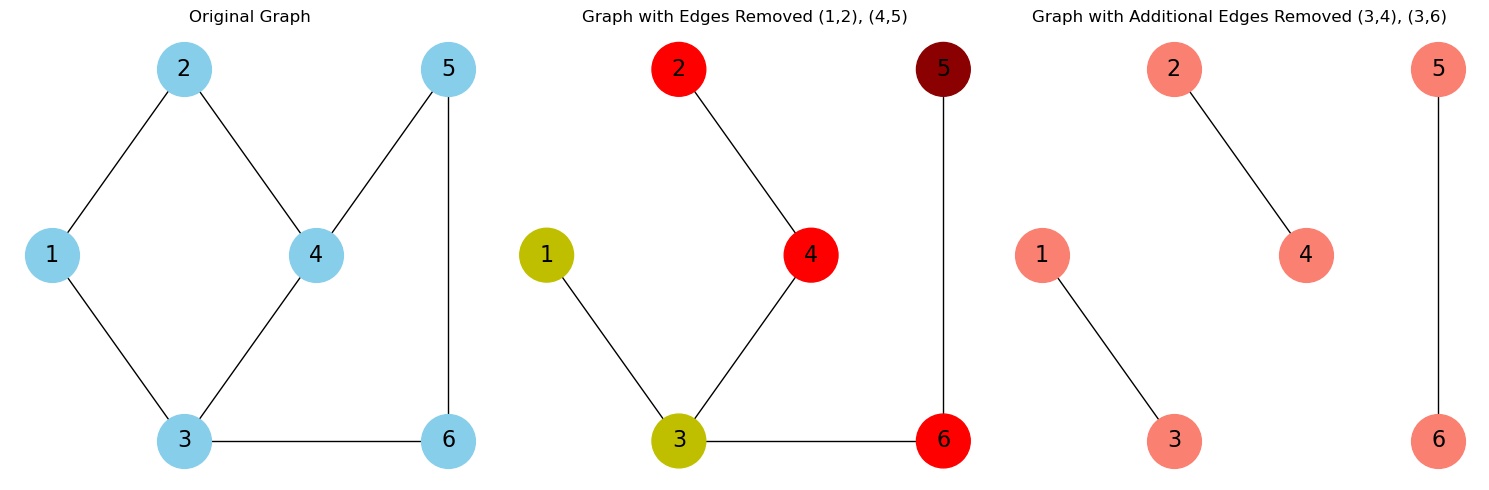

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the initial graph
G = nx.Graph()

# Add nodes
nodes = [1, 2, 3, 4, 5, 6]
G.add_nodes_from(nodes)

# Add edges
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (5, 6), (3, 6)]
G.add_edges_from(edges)

# Define fixed positions for the nodes
fixed_positions = {
    1: (0, 2),
    2: (1, 3),
    3: (1, 1),
    4: (2, 2),
    5: (3, 3),
    6: (3, 1)
}

# Plot 1: Original Graph
plt.figure(figsize=(15, 5))
plt.subplot(131)  # 1 row, 3 columns, 1st subplot
nx.draw(G, pos=fixed_positions, with_labels=True, node_color='skyblue', edge_color='black', node_size=1500, font_size=16)
plt.title("Original Graph")

# Plot 2: Remove some edges and plot
G2 = G.copy()
edges_to_remove_2 = [(1, 2), (4, 5)]
G2.remove_edges_from(edges_to_remove_2)

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
nx.draw(G2, pos=fixed_positions, with_labels=True, node_color=['y', 'r', 'y', 'r', 'darkred', 'r'], edge_color='black', node_size=1500, font_size=16)
plt.title("Graph with Edges Removed (1,2), (4,5)")

# Plot 3: Remove more edges and plot
G3 = G2.copy()
edges_to_remove_3 = [(3, 4), (3, 6)]
G3.remove_edges_from(edges_to_remove_3)

plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
nx.draw(G3, pos=fixed_positions, with_labels=True, node_color='salmon', edge_color='black', node_size=1500, font_size=16)
plt.title("Graph with Additional Edges Removed (3,4), (3,6)")

# Show all plots
plt.tight_layout()
plt.show()
